In [2]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, svm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import copy
import warnings
import random

random.seed(42)

%matplotlib inline

##### CM Taken from scikit learn docu

In [155]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('CM_LR.png', format='png', dpi=1000)

In [4]:
plt.clf()
### ROC CURVES 
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
def get_ROC(y_pred, y_true):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(1):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred == i)
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label = 'Class {} - AUC Score: {}'.format(i, roc_auc[i]))
        plt.legend()
        #plt.savefig('AUC_Logistic_Regression.png', format='png')

<Figure size 432x288 with 0 Axes>

In [177]:
au_df = pd.read_csv('AU_df.csv', index_col=False)
bellevue_df = pd.read_csv('Bellevue_final_data.csv', index_col=False)

bellevue_clean_df = bellevue_df.iloc[:, 0:4]
bellevue_clean_df.rename(columns={'pcl_1m_cutoff': 'PTSD', 'SelfReport_Age': 'Age'}, inplace=True)

merged_df = bellevue_clean_df.merge(au_df, on='ID')
merged_df = merged_df.dropna()


train_data = merged_df.drop('ID', axis=1)
print(train_data.groupby('PTSD').count())
#pca_data = copy.deepcopy(train_data)
labels = merged_df['PTSD']
train_data = train_data.drop('PTSD', axis=1)
train_data2 = copy.deepcopy(train_data)
train_data = StandardScaler().fit_transform(train_data)
print(train_data.shape)
labels.values

      Sex  Age   AU01_r   AU02_r   AU04_r   AU05_r   AU06_r   AU07_r   AU09_r  \
PTSD                                                                            
0.0    51   51       51       51       51       51       51       51       51   
1.0    24   24       24       24       24       24       24       24       24   

       AU10_r   ...      AU12_c   AU14_c   AU15_c   AU17_c   AU20_c   AU23_c  \
PTSD            ...                                                            
0.0        51   ...          51       51       51       51       51       51   
1.0        24   ...          24       24       24       24       24       24   

       AU25_c   AU26_c   AU28_c   AU45_c  
PTSD                                      
0.0        51       51       51       51  
1.0        24       24       24       24  

[2 rows x 37 columns]
(75, 37)


array([0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1.])

In [6]:
train_class, test_class, train_labels, test_labels = train_test_split(train_data, labels, test_size = 0.20, random_state = 42)
print('Training Features Shape:', train_class.shape)
print('Training Labels Shape:\t', train_labels.shape)
print('Testing Features Shape:\t', test_class.shape)
print('Testing Labels Shape:\t', test_labels.shape)

Training Features Shape: (60, 37)
Training Labels Shape:	 (60,)
Testing Features Shape:	 (15, 37)
Testing Labels Shape:	 (15,)


In [147]:
print(train_data2.columns)

Index(['Sex', 'Age', ' AU01_r', ' AU02_r', ' AU04_r', ' AU05_r', ' AU06_r',
       ' AU07_r', ' AU09_r', ' AU10_r', ' AU12_r', ' AU14_r', ' AU15_r',
       ' AU17_r', ' AU20_r', ' AU23_r', ' AU25_r', ' AU26_r', ' AU45_r',
       ' AU01_c', ' AU02_c', ' AU04_c', ' AU05_c', ' AU06_c', ' AU07_c',
       ' AU09_c', ' AU10_c', ' AU12_c', ' AU14_c', ' AU15_c', ' AU17_c',
       ' AU20_c', ' AU23_c', ' AU25_c', ' AU26_c', ' AU28_c', ' AU45_c'],
      dtype='object')


### Logsitic Regression & Grid Search

In [8]:
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')
def lr_param_selection(X, y):
    Cs = [0.001, 0.01, 0.1, 1, 10, 20, 50]
    max_iter = [10, 100, 1000, 10000, 20000]
    solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    class_weight = [None, 'balanced']
    param_grid = {'C': Cs,  'solver': solver, 'max_iter' : max_iter, 'class_weight': class_weight}
    grid_search = GridSearchCV(LogisticRegression(), param_grid, verbose=False)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

lr_params = lr_param_selection(train_class, train_labels)
print(lr_params)

{'C': 0.01, 'class_weight': None, 'max_iter': 10, 'solver': 'saga'}


Logistic Regression Accuracy:  0.7333333333333333
Confusion matrix, without normalization
[[11  0]
 [ 4  0]]


/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


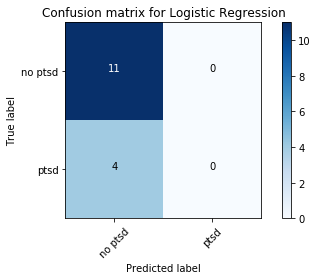

In [48]:
lr = LogisticRegression(C = 0.001, class_weight= None , max_iter = 10, solver= 'saga')
#lr = LogisticRegression(C = 0.1, class_weight= None , max_iter = 10, solver= 'newton-cg')


lr.fit(train_class, train_labels)
lr_pred = lr.predict(test_class)
lr_acc = metrics.accuracy_score(lr_pred, test_labels)
print('Logistic Regression Accuracy: ', lr_acc)
conf_mat = metrics.confusion_matrix(test_labels, lr_pred)
plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
                      title='Confusion matrix for Logistic Regression')


### RFE Functions

Able to find the important 'n' features of the model, where 'n' is the number of features specified (default=3)

In [10]:
def RFE_model(model, data, labels, train_data, num_attr=3):
    """Generate an RFE model given any previous model; number of attributes defaults to 3 but can
    be changed. Returns a dictionary with feature name as the key and ranking/support of RFE as value."""
    rfe = RFE(model, num_attr)
    rfe = rfe.fit(data, labels)
    # Creating the feature dictionary
    feat_dict = {}
    count = 0
    for col in train_data.columns:
        feat_dict[col] = [rfe.ranking_[count], rfe.support_[count]]
        count +=1
    return feat_dict

def get_important_features(feat_dict):
    """Getting a print out of the most important features in the model"""
    imp_feat = []
    for k, v in feat_dict.items():
        if v[0] == 1: # looking only for features labelled as number 1
            imp_feat.append(k)
    return imp_feat
    
# feat_dict = RFE_model(lr, train_class, train_labels, train_data2, 20)
# imp_feat = get_important_features(feat_dict)
# print(imp_feat)

In [11]:
train_data_rfe = copy.deepcopy(train_data2)
for col in train_data_rfe.columns:
    if col not in imp_feat:
        train_data_rfe = train_data_rfe.drop(col, axis=1) 
        
train_data_rfe = StandardScaler().fit_transform(train_data_rfe)
train_class_rfe, test_class_rfe, train_labels_rfe, test_labels_rfe = train_test_split(train_data_rfe, labels, test_size = 0.20, random_state = 42)
lr_param_selection(train_class_rfe, train_labels_rfe)

{'C': 0.001, 'class_weight': 'balanced', 'max_iter': 10, 'solver': 'saga'}

In [47]:
lr = LogisticRegression(C = 0.001, class_weight= None , max_iter = 10, solver= 'newton-cg')


lr.fit(train_class_rfe, train_labels_rfe)
lr_pred = lr.predict(test_class_rfe)
lr_acc = metrics.accuracy_score(lr_pred, test_labels_rfe)
print('Logistic Regression Accuracy: ', lr_acc)
conf_mat = metrics.confusion_matrix(test_labels_rfe, lr_pred)
plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
                      title='Confusion matrix for Logistic Regression with RFE (20 variables)')

NameError: name 'train_class_rfe' is not defined

### Random Forest & Grid Search

In [67]:
warnings.filterwarnings('ignore')
def rf_param_selection(X, y):
    n_estimators = [1, 10, 20, 50, 100, 200,  1000]
    max_depth = [None, 10, 100, 200]
    max_features = ['auto','sqrt', None, 'log2']
    min_samples_split = [2,3,4,5,10]
    min_samples_leaf = [1,2,4, 5]
    bootstrap = [True, False]
    param_grid = {'n_estimators': n_estimators, 
                  'max_depth': max_depth,
                  'max_features': max_features,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'bootstrap': bootstrap
                 }
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid, verbose=False)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

rf_params = rf_param_selection(train_class, train_labels)
print(rf_params)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 10}


Random Forest Accuracy:  0.7333333333333333
Confusion matrix, without normalization
[[10  1]
 [ 3  1]]


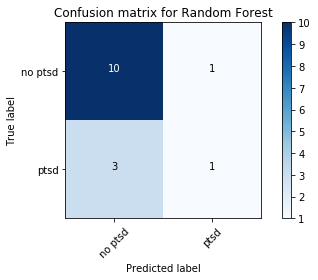

In [74]:
random.seed(42)
rf = RandomForestClassifier(bootstrap=True, max_depth=10, max_features='auto', min_samples_leaf=4, min_samples_split=3, n_estimators=10)
rf.fit(train_class, train_labels)
rf_pred = rf.predict(test_class)
rf_acc = metrics.accuracy_score(rf_pred, test_labels)
print('Random Forest Accuracy: ', rf_acc)

conf_mat = metrics.confusion_matrix(test_labels, rf_pred)
plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
                      title='Confusion matrix for Random Forest')

In [71]:
get_ROC(rf_pred, test_labels)

TypeError: 'numpy.float64' object is not callable

#### Linear SVM

Linear SVM Accuracy:  0.6
Confusion matrix, without normalization
[[7 2]
 [4 2]]


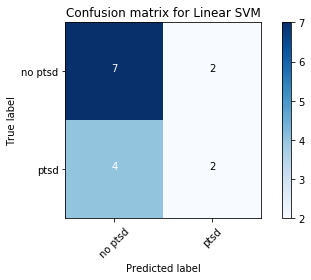

In [50]:
lin_svm = svm.SVC(kernel='linear', C=10)
lin_svm.fit(train_class, train_labels)
lin_svm_pred = lin_svm.predict(test_class)
svm_lin_acc = metrics.accuracy_score(lin_svm_pred, test_labels)
print('Linear SVM Accuracy: ', svm_lin_acc)
conf_mat = metrics.confusion_matrix(lin_svm_pred, test_labels)
plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
                      title='Confusion matrix for Linear SVM')

In [68]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10, 20, 50]
    gammas = [0.001, 0.01, 0.1, 1, 2]
    kernel = ['poly']
    max_iter = [-1, 1, 5, 10, 100, 1000]
    param_grid = {'C': Cs, 'gamma' : gammas, 'kernel': kernel, 'max_iter': max_iter}
    grid_search = GridSearchCV(svm.SVC(), param_grid)#, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

print(svc_param_selection(train_class, train_labels, 2))

{'C': 0.001, 'gamma': 0.001, 'kernel': 'poly', 'max_iter': -1}


Poly SVM Accuracy:  0.6
Confusion matrix, without normalization
[[8 3]
 [3 1]]


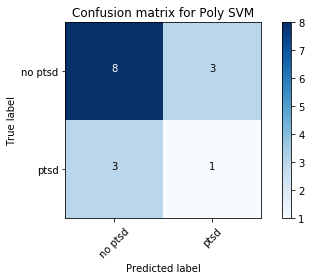

In [51]:
poly_svm = svm.SVC(kernel='poly', C=1, gamma=0.1, max_iter=1000)
poly_svm.fit(train_class, train_labels)
poly_svm_pred = poly_svm.predict(test_class)
svm_poly_acc = metrics.accuracy_score(poly_svm_pred, test_labels)
print('Poly SVM Accuracy: ', svm_poly_acc)
conf_mat = metrics.confusion_matrix(test_labels, poly_svm_pred)
plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
                      title='Confusion matrix for Poly SVM')

Radial SVM Accuracy:  0.7333333333333333
Confusion matrix, without normalization
[[11  0]
 [ 4  0]]


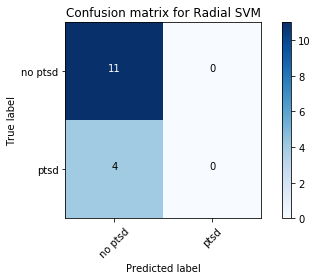

In [52]:
rad_svm = svm.SVC(kernel='rbf', C=0.001, gamma=0.001, max_iter=-1)
rad_svm.fit(train_class, train_labels)
rad_svm_pred = rad_svm.predict(test_class)
svm_rad_acc = metrics.accuracy_score(rad_svm_pred, test_labels)
print('Radial SVM Accuracy: ', svm_rad_acc)
conf_mat = metrics.confusion_matrix(test_labels, rad_svm_pred)
plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
                      title='Confusion matrix for Radial SVM')

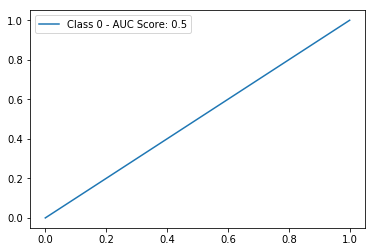

In [37]:
rad_roc = get_ROC(rad_svm_pred, test_labels)


### K Nearest Neighbor

In [143]:
k_range = list(range(1, 30))
def knn_param_selection(X, y, nfolds):
    param_grid = dict(n_neighbors=k_range)
    knn = KNeighborsClassifier(n_neighbors=5)
    grid_search = GridSearchCV(knn, param_grid, cv=nfolds, scoring='accuracy')
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_
print(knn_param_selection(train_class, train_labels, 10))

{'n_neighbors': 2}


KNN Accuracy:  0.6666666666666666
Confusion matrix, without normalization
[[9 2]
 [3 1]]


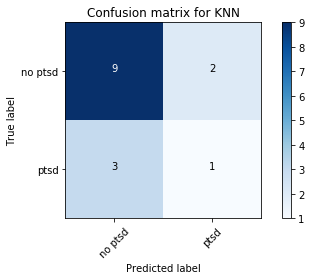

In [144]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(train_class, train_labels)

neigh_pred = neigh.predict(test_class)
neigh_acc = metrics.accuracy_score(neigh_pred, test_labels)

print('KNN Accuracy: ', neigh_acc)
conf_mat = metrics.confusion_matrix(test_labels, neigh_pred)
plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
                      title='Confusion matrix for KNN')


## PCA

In [133]:
from sklearn.decomposition import KernelPCA, PCA

pca_data = merged_df.drop('ID', axis=1)
pca_data = pca_data.dropna()


x = pca_data.loc[: , 'Age':]

y = pca_data.loc[:, "PTSD"]

x.shape

(75, 36)

In [ ]:
def run_PCA(kern):
    pca = KernelPCA(kernel=kern)
    principalComponents = pca.fit_transform(x)
    print(principalComponents.shape)
    principalDf = pd.DataFrame(data = principalComponents)
    finalDf = pd.concat([principalDf, pca_data[['PTSD']]], axis = 1)
    eigen_vals = pca.lambdas_
    eigen_vecs = pca.alphas_
    tot = sum(eigen_vals)
    var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
    print(var_exp)
    cum_var_exp = np.cumsum(var_exp)
    print(finalDf.head())
    print(finalDf.shape)
    return finalDf, var_exp

def plot_PCA(finalDf, var_exp, kern):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1 (%.2f %%)' % (var_exp[0] * 100) , fontsize = 15)
    ax.set_ylabel('Principal Component 2 (%.2f %%)' % (var_exp[1] * 100) , fontsize = 15)
    ax.set_title('%s PCA on PTSD' % kern , fontsize = 20)
    targets = [0, 1]
    colors = ['r', 'g', 'b']
    for target, color in zip(targets,colors):
        idx_to_keep = finalDf['PTSD'] == target
#         ax.scatter(finalDf.loc[idx_to_keep, 'principal component 1'],
#                finalDf.loc[idx_to_keep, 'principal component 2'],
#                c = color,
#                s = 50)
        ax.scatter(finalDf.loc[idx_to_keep, 0],
               finalDf.loc[idx_to_keep, 1],
               c = color,
               s = 50)
    leg = ['No PTSD', 'PTSD']
    ax.legend(leg)
    ax.grid()
    plt.savefig('PCA_%s.png' % kern, format='png', dpi=600)

In [ ]:
lin_pca, var_exp = run_PCA(kern='linear')
plot_PCA(lin_pca, var_exp, 'Linear')

[0.29287465413559505, 0.1900337099454122, 0.08785537757405797, 0.05713225283643408, 0.04754388661602224, 0.039668369551927866, 0.03531399786802921, 0.02968646952357909, 0.025520284889703773, 0.023179376272266305, 0.018232498983047154, 0.015883801902261383, 0.013705397801860832, 0.012655145478209858, 0.010919506293914952, 0.00979325652651296, 0.008953933620626239, 0.007426727093735219, 0.006709469744090072, 0.006028479813550884, 0.005482540384727875, 0.00484923263541301, 0.00438725461160709, 0.0037311926717005063, 0.0035038594311853142, 0.0033335138533404575, 0.003121627995670383, 0.0030192359405585485, 0.0027862051042842097, 0.0024674949137655374, 0.002233814278571242, 0.0020041303646736943, 0.0017846978197549456, 0.001664650098414674, 0.0014031555281984642, 0.001296905704290437, 0.0012518763464778972, 0.001163933330994569, 0.0011326441286151543, 0.00102097614412076, 0.0009236187962872282, 0.0008569387164199694, 0.000838577541854455, 0.0007290788771669379, 0.0006455399339264232, 0.0005

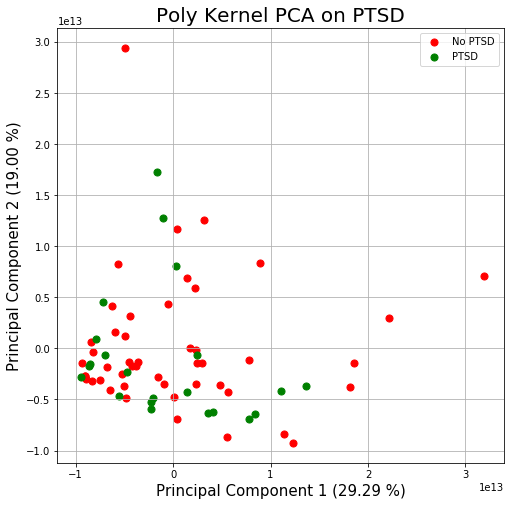

In [126]:
poly_pca, var_exp = run_PCA(kern='poly')
plot_PCA(poly_pca, var_exp, 'Poly Kernel')

[0.330129278786372, 0.1560937127417108, 0.09063746525730393, 0.0713649109046873, 0.06672288068907599, 0.0645994038051941, 0.04750425779667031, 0.0341153714759411, 0.02605468012430943, 0.023742436575525532, 0.020454265457612045, 0.018355615572247026, 0.016706711356495, 0.01244663111383687, 0.009470052927996327, 0.005765086669195311, 0.0040901302267506625, 0.0017470348933320173, 7.270762423819456e-08, 4.685739470863517e-10, 1.8738149484292478e-10, 5.27956135987294e-11, 4.457468192706797e-11, 4.192645299413932e-11, 2.3430406241221643e-11, 2.1052737378872183e-11, 1.7584191628810137e-11, 1.3770593195045601e-11, 1.2422579519300076e-11, 9.050908003452963e-12, 7.92240220487308e-12, 6.346036051546989e-12, 5.023028358610721e-12, 3.093983188385147e-12, 1.9404398925280582e-12, 1.2298242898057298e-12, 4.2865615169085447e-16, 3.00305046876995e-17, 1.9796673031662185e-17, 1.1172843197906076e-17, 1.006940148282192e-17, 7.15779219631152e-18, 6.5820143689635106e-18, 5.464491909935674e-18, 4.713888449017

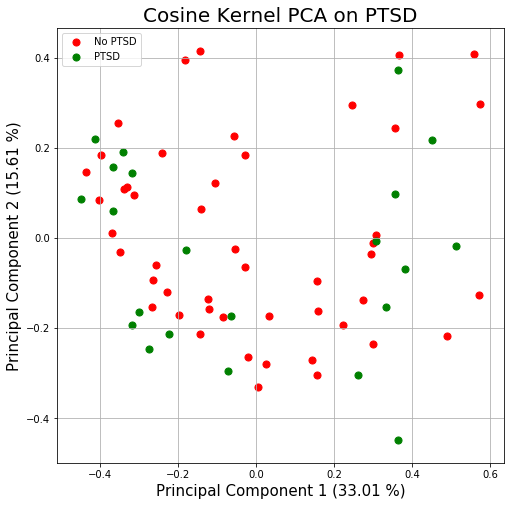

In [127]:
cos_pca, var_exp = run_PCA(kern='cosine')
plot_PCA(cos_pca, var_exp, 'Cosine Kernel')

[0.013513513513513535, 0.013513513513513532, 0.013513513513513532, 0.013513513513513532, 0.013513513513513525, 0.013513513513513525, 0.013513513513513525, 0.013513513513513523, 0.013513513513513523, 0.01351351351351352, 0.01351351351351352, 0.013513513513513516, 0.013513513513513516, 0.013513513513513516, 0.013513513513513516, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513514, 0.013513513513513513, 0.013513513513513513, 0.013513513

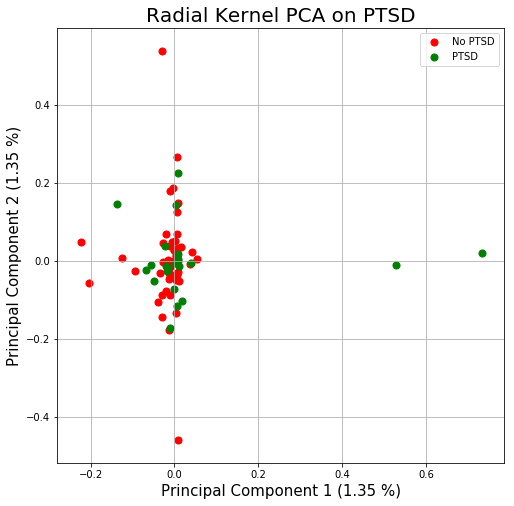

In [128]:
rad_pca, var_exp = run_PCA(kern='rbf')
plot_PCA(rad_pca, var_exp, 'Radial Kernel')

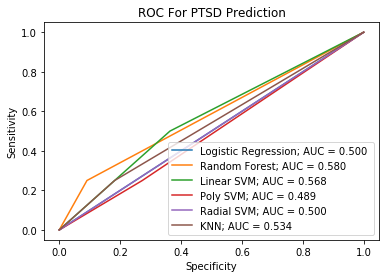

In [89]:
plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(test_labels, lr_pred)
auc = metrics.roc_auc_score(test_labels, lr_pred)
plt.plot(fpr,tpr,label="Logistic Regression; AUC = %.3f "% auc)


fpr, tpr, thresh = metrics.roc_curve(test_labels, rf_pred)
auc = metrics.roc_auc_score(test_labels, rf_pred)
plt.plot(fpr,tpr,label="Random Forest; AUC = %.3f " % auc)

fpr, tpr, thresh = metrics.roc_curve(test_labels, lin_svm_pred)
auc = metrics.roc_auc_score(test_labels, lin_svm_pred)
plt.plot(fpr,tpr,label="Linear SVM; AUC = %.3f " % auc)

fpr, tpr, thresh = metrics.roc_curve(test_labels, poly_svm_pred)
auc = metrics.roc_auc_score(test_labels, poly_svm_pred)
plt.plot(fpr,tpr,label="Poly SVM; AUC = %.3f " % auc)

fpr, tpr, thresh = metrics.roc_curve(test_labels, rad_svm_pred)
auc = metrics.roc_auc_score(test_labels, rad_svm_pred)
plt.plot(fpr,tpr,label="Radial SVM; AUC = %.3f " % auc)

fpr, tpr, thresh = metrics.roc_curve(test_labels, neigh_pred)
auc = metrics.roc_auc_score(test_labels, neigh_pred)
plt.plot(fpr,tpr,label="KNN; AUC = %.3f " % auc)

plt.title('ROC For PTSD Prediction')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc=4)
plt.savefig('ROC_Plot.png', format='png')

In [57]:
plt.clf()
### ROC CURVES 
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
def get_ROC2(y_pred, y_true):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(1):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred == i)
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label = 'AUC: %.3f ' % roc_auc[i], color='purple', lw=2)
        plt.plot([0, 1], [0, 1], color='lightgrey', lw=2, linestyle='-')
        plt.legend(loc="lower right")
        plt.grid(color='whitesmoke', lw=0.5)
        plt.title('Lin SVM', size=14)
        plt.xlabel('Specificity')
        plt.ylabel('Sensitivity')
        plt.savefig('AUC_SVM.png', format='png')

<Figure size 432x288 with 0 Axes>

0.7333333333333333
0.7333333333333333
0.7333333333333333
0.7333333333333333
0.7333333333333333
0.7333333333333333
['Age', ' AU01_r', ' AU05_r', ' AU06_r', ' AU25_r', ' AU45_r', ' AU09_c', ' AU15_c']


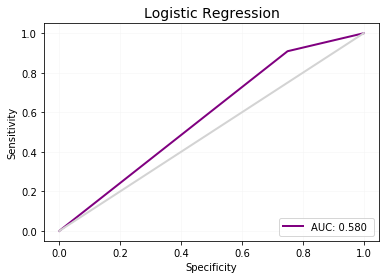

In [45]:
random.seed(42)
lr = LogisticRegression(solver='lbfgs')


def lr_RFE(model, train_class, train_labels, data):
    best_acc = 0
    selected_feat = None
    optimal_feat = 0
    for i in range(1,train_class.shape[1]):
        num_feat = i
        feat_dict = RFE_model(model, train_class, train_labels, data, i)
        imp_feat = get_important_features(feat_dict)
        
        train_data_rfe = copy.deepcopy(train_data2)
        for col in train_data_rfe.columns:
            if col not in imp_feat:
                train_data_rfe = train_data_rfe.drop(col, axis=1) 
        
        train_data_rfe = StandardScaler().fit_transform(train_data_rfe)
        train_class_rfe, test_class_rfe, train_labels_rfe, test_labels_rfe = train_test_split(train_data_rfe, labels, test_size = 0.20, random_state = 42)
        
        lr.fit(train_class_rfe, train_labels_rfe)
        lr_pred_rfe = lr.predict(test_class_rfe)
        lr_acc = metrics.accuracy_score(lr_pred_rfe, test_labels_rfe)
        
        if lr_acc >= best_acc and  i < 40:
            selected_feat = imp_feat
            best_acc = lr_acc
            optimal_feat = i
            y_pred = lr_pred_rfe
            y_true = test_labels_rfe
            print(best_acc)
#     plt.tight_layout()
#     plt.subplot(2, 1, 1)
    print(selected_feat)
    get_ROC2(y_pred, y_true)
#     plt.subplot(2, 1, 2)
#     conf_mat = metrics.confusion_matrix(y_true, y_pred)
#     plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
#                       title='Confusion matrix for Logistic Regression')
    return optimal_feat,  best_acc, selected_feat, y_pred
optimal_f, best_a, sel_feat, y_pred_lr_rfe = lr_RFE(lr, train_class, train_labels, train_data2)

0.5333333333333333
0.6666666666666666
0.7333333333333333
[' AU02_r', ' AU05_r', ' AU12_r', ' AU17_r', ' AU20_r', ' AU45_r', ' AU12_c', ' AU23_c', ' AU26_c']


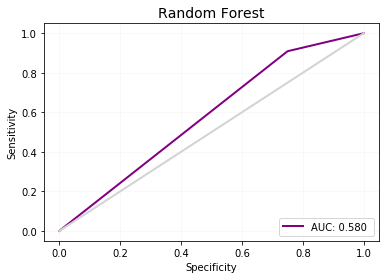

In [40]:
random.seed(42)
rf = RandomForestClassifier(n_estimators=100)


def RF_RFE(model, train_class, train_labels, data):
    best_acc = 0
    selected_feat = None
    optimal_feat = 0
    for i in range(1,train_class.shape[1]):
        num_feat = i
        feat_dict = RFE_model(model, train_class, train_labels, data, i)
        imp_feat = get_important_features(feat_dict)
        
        train_data_rfe = copy.deepcopy(train_data2)
        for col in train_data_rfe.columns:
            if col not in imp_feat:
                train_data_rfe = train_data_rfe.drop(col, axis=1) 
        
        train_data_rfe = StandardScaler().fit_transform(train_data_rfe)
        train_class_rfe, test_class_rfe, train_labels_rfe, test_labels_rfe = train_test_split(train_data_rfe, labels, test_size = 0.20, random_state = 42)
        
        rf.fit(train_class_rfe, train_labels_rfe)
        rf_pred_rfe = rf.predict(test_class_rfe)
        rf_acc = metrics.accuracy_score(rf_pred_rfe, test_labels_rfe)
        
        if rf_acc > best_acc:
            selected_feat = imp_feat
            best_acc = rf_acc
            optimal_feat = i
            y_pred = rf_pred_rfe
            y_true = test_labels_rfe
            print(best_acc)
#     plt.tight_layout()
#     plt.subplot(2, 1, 1)
    print(selected_feat)
    get_ROC2(y_pred, y_true)
#     plt.subplot(2, 1, 2)
#     conf_mat = metrics.confusion_matrix(y_true, y_pred)
#     plot_confusion_matrix(conf_mat, classes=['no ptsd', 'ptsd'],
#                       title='Confusion matrix for Logistic Regression')
    
    return optimal_feat,  best_acc, selected_feat, y_pred, y_true
optimal_feat_rf, best_acc_rf, selected_feat_rf, y_pred_rf_rfe, y_true_rf_rfe = RF_RFE(rf, train_class, train_labels, train_data2)

In [28]:
from sklearn.model_selection import GridSearchCV
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10, 20, 50]
    gammas = [0.001, 0.01, 0.1, 1, 2]
    kernel = ['linear']
    max_iter = [-1, 1, 5, 10, 100, 1000]
    param_grid = {'C': Cs, 'gamma' : gammas, 'kernel': kernel, 'max_iter': max_iter}
    grid_search = GridSearchCV(svm.SVC(), param_grid)#, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

print(svc_param_selection(train_class, train_labels, 2))

/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/E

/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/Eden/anaconda3/li

/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/Eden/anaco

/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/Eden/anacond

{'C': 0.001, 'gamma': 0.001, 'kernel': 'linear', 'max_iter': -1}


/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/Eden/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/Eden/anaconda3

0.7333333333333333


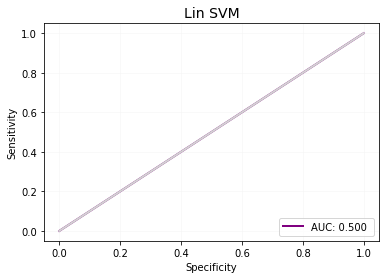

In [64]:

svm_lin =svm.SVC(kernel='linear', C=0.001, gamma=0.001, max_iter=-1)


def SVM_RFE(model, train_class, train_labels, data):
    best_acc = 0
    selected_feat = None
    optimal_feat = 0
    for i in range(1,train_class.shape[1]):
        num_feat = i
        feat_dict = RFE_model(model, train_class, train_labels, data, i)
        imp_feat = get_important_features(feat_dict)
        
        train_data_rfe = copy.deepcopy(train_data2)
        for col in train_data_rfe.columns:
            if col not in imp_feat:
                train_data_rfe = train_data_rfe.drop(col, axis=1) 
        
        train_data_rfe = StandardScaler().fit_transform(train_data_rfe)
        train_class_rfe, test_class_rfe, train_labels_rfe, test_labels_rfe = train_test_split(train_data_rfe, labels, test_size = 0.20, random_state = 42)
        
        model.fit(train_class_rfe, train_labels_rfe)
        svm_lin_pred_rfe = model.predict(test_class_rfe)
        svm_lin_acc = metrics.accuracy_score(svm_lin_pred_rfe, test_labels_rfe)
        
        if svm_lin_acc > best_acc:
            selected_feat = imp_feat
            best_acc = svm_lin_acc
            optimal_feat = i
            y_pred = svm_lin_pred_rfe
            y_true = test_labels_rfe
            print(best_acc)

    get_ROC2(y_pred, y_true)
    
    
    return optimal_feat,  best_acc, selected_feat, y_pred

a, b, c, y_pred_svm_rfe = SVM_RFE(svm_lin, train_class, train_labels, train_data2)

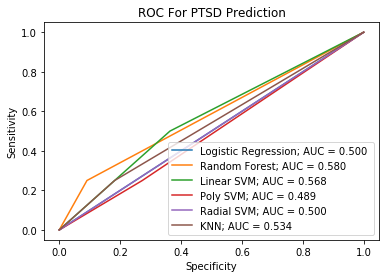

In [145]:
plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(test_labels, lr_pred)
auc = metrics.roc_auc_score(test_labels, lr_pred)
plt.plot(fpr,tpr,label="Logistic Regression; AUC = %.3f "% auc)


fpr, tpr, thresh = metrics.roc_curve(test_labels, rf_pred)
auc = metrics.roc_auc_score(test_labels, rf_pred)
plt.plot(fpr,tpr,label="Random Forest; AUC = %.3f " % auc)

fpr, tpr, thresh = metrics.roc_curve(test_labels, lin_svm_pred)
auc = metrics.roc_auc_score(test_labels, lin_svm_pred)
plt.plot(fpr,tpr,label="Linear SVM; AUC = %.3f " % auc)

fpr, tpr, thresh = metrics.roc_curve(test_labels, poly_svm_pred)
auc = metrics.roc_auc_score(test_labels, poly_svm_pred)
plt.plot(fpr,tpr,label="Poly SVM; AUC = %.3f " % auc)

fpr, tpr, thresh = metrics.roc_curve(test_labels, rad_svm_pred)
auc = metrics.roc_auc_score(test_labels, rad_svm_pred)
plt.plot(fpr,tpr,label="Radial SVM; AUC = %.3f " % auc)

fpr, tpr, thresh = metrics.roc_curve(test_labels, neigh_pred)
auc = metrics.roc_auc_score(test_labels, neigh_pred)
plt.plot(fpr,tpr,label="KNN; AUC = %.3f " % auc)


plt.title('ROC For PTSD Prediction')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc=4)
plt.savefig('ROC_Plot_Revised.png', format='png', dpi=800)




0.0

In [159]:
lr_f1= metrics.f1_score(test_labels, lr_pred)
rf_f1= metrics.f1_score(test_labels, rf_pred)
lin_svm_f1 = metrics.f1_score(test_labels, lin_svm_pred)
poly_svm_f1 = metrics.f1_score(test_labels, poly_svm_pred)
rad_svm_f1 = metrics.f1_score(test_labels, rad_svm_pred)
knn_f1 = metrics.f1_score(test_labels, neigh_pred)

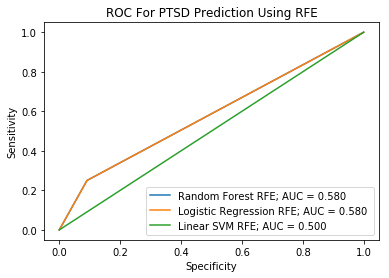

In [137]:

plt.figure(0).clf()


fpr, tpr, thresh = metrics.roc_curve(test_labels, y_pred_rf_rfe)
auc = metrics.roc_auc_score(test_labels, y_pred_rf_rfe)
plt.plot(fpr,tpr,label="Random Forest RFE; AUC = %.3f " % auc)

fpr, tpr, thresh = metrics.roc_curve(test_labels, y_pred_lr_rfe)
auc = metrics.roc_auc_score(test_labels, y_pred_lr_rfe)
plt.plot(fpr,tpr,label="Logistic Regression RFE; AUC = %.3f " % auc)

fpr, tpr, thresh = metrics.roc_curve(test_labels, y_pred_svm_rfe)
auc = metrics.roc_auc_score(test_labels, y_pred_svm_rfe)
plt.plot(fpr,tpr,label="Linear SVM RFE; AUC = %.3f " % auc)

plt.title('ROC For PTSD Prediction Using RFE')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc=4)
plt.savefig('ROC_RFE_Plot_Revised.png', format='png', dpi=800)



In [160]:
lr_f1_rfe= metrics.f1_score(test_labels, y_pred_lr_rfe)
rf_f1_rfe= metrics.f1_score(test_labels, y_pred_rf_rfe)
lin_svm_f1_rfe = metrics.f1_score(test_labels, y_pred_svm_rfe)

In [161]:
print(lr_f1, lr_f1_rfe)
print(rf_f1, rf_f1_rfe)
print(lin_svm_f1, lin_svm_f1_rfe)
print(rad_svm_f1, poly_svm_f1, knn_f1)

0.0 0.3333333333333333
0.3333333333333333 0.3333333333333333
0.4 0.0
0.0 0.25 0.28571428571428575


Average precision-recall score: 0.38


Text(0.5,1,'2-class Precision-Recall curve: AP=0.38')

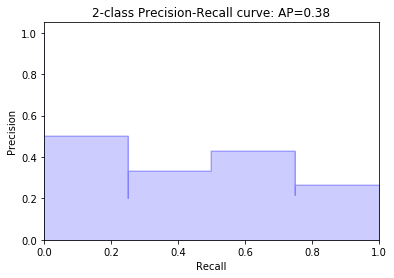

In [165]:
from sklearn.metrics import precision_recall_curve
from inspect import signature
lr = LogisticRegression(C = 0.001, class_weight= None , max_iter = 10, solver= 'newton-cg')
lr.fit(train_class, train_labels)



y_score_lr = lr.decision_function(test_class)


from sklearn.metrics import average_precision_score
average_precision = average_precision_score(test_labels, y_score_lr)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
precision, recall, _ = precision_recall_curve(test_labels, y_score_lr)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

Confusion matrix, without normalization
[[10  1]
 [ 3  1]]


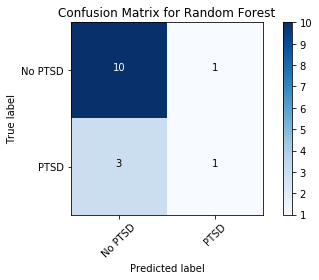

In [150]:
conf_mat = metrics.confusion_matrix(test_labels, rf_pred)
plot_confusion_matrix(conf_mat, classes=['No PTSD', 'PTSD'],
                      title='Confusion Matrix for Random Forest')

Confusion matrix, without normalization
[[10  1]
 [ 3  1]]


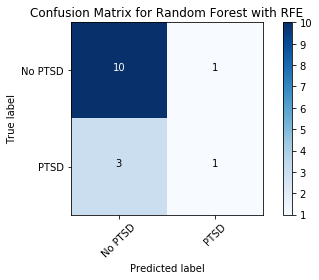

In [152]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred_rf_rfe)
plot_confusion_matrix(conf_mat, classes=['No PTSD', 'PTSD'],
                      title='Confusion Matrix for Random Forest with RFE')

Confusion matrix, without normalization
[[10  1]
 [ 3  1]]


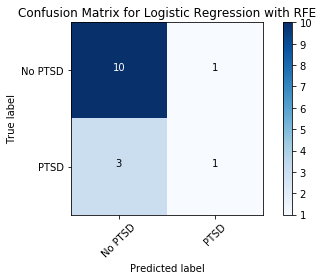

In [154]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred_lr_rfe)
plot_confusion_matrix(conf_mat, classes=['No PTSD', 'PTSD'],
                      title='Confusion Matrix for Logistic Regression with RFE')

Confusion matrix, without normalization
[[11  0]
 [ 4  0]]


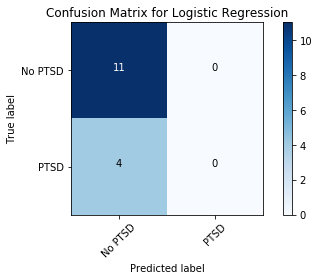

In [156]:
conf_mat = metrics.confusion_matrix(test_labels, lr_pred)
plot_confusion_matrix(conf_mat, classes=['No PTSD', 'PTSD'],
                      title='Confusion Matrix for Logistic Regression')